/tmp/ipykernel_615/1647476483.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')


Anomaly Scores (higher = more normal, lower = more anomalous):
                     anomaly_score  is_anomaly
hour                                          
2025-07-05 16:00:00       0.064979           1
2025-07-08 19:00:00       0.172375           1
2025-07-08 20:00:00       0.157840           1
2025-07-08 21:00:00       0.148332           1
2025-07-08 22:00:00       0.207486           1
2025-07-09 13:00:00      -0.097469          -1
2025-07-09 14:00:00       0.204339           1


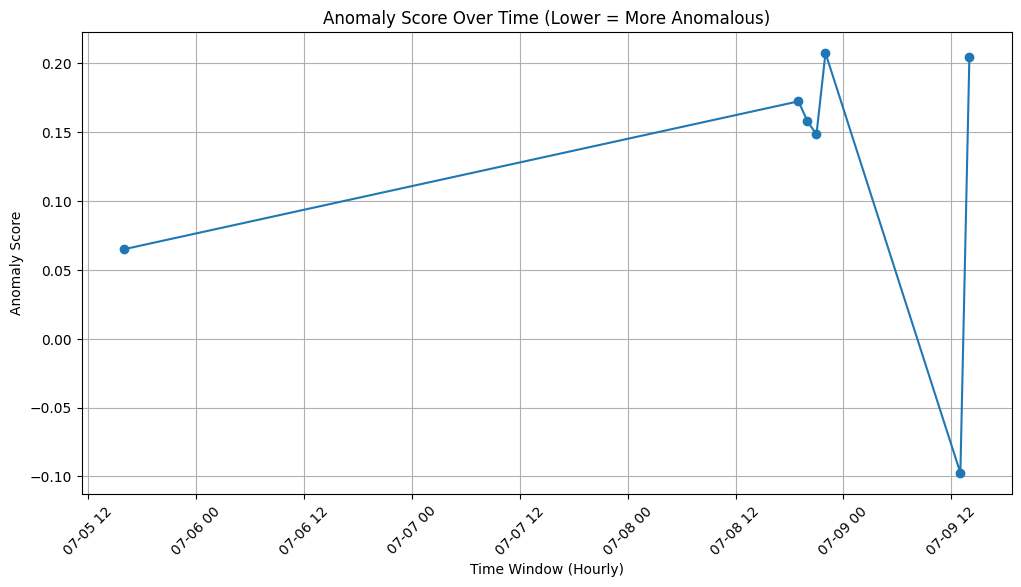


Top Contributing Terms for Each Anomaly:

Anomalous Hour: 2025-07-09 13:00:00
started              164.749841
created              162.758556
container            128.013859
created container     82.753922
created created       82.263293
started container     82.027821
started started       81.541957
dev                   71.881948
failed                64.272316
operator              55.832320
Name: 2025-07-09 13:00:00, dtype: float64

Top Terms for Specific Hour 2025-07-09 13:00:00:
started              164.749841
created              162.758556
container            128.013859
created container     82.753922
created created       82.263293
started container     82.027821
started started       81.541957
dev                   71.881948
failed                64.272316
operator              55.832320
Name: 2025-07-09 13:00:00, dtype: float64


In [11]:
import pandas as pd
import json
from datetime import datetime
import re
# Step 2: Preprocess and Clean Text Fields
# Combine 'reason' and 'message' into one text field
#read from input 1
df=pd.read_csv("/data/1_load_event_data_output.csv")
df['text'] = df['reason'] + ' ' + df['message']

# Remove hash-like words (hexadecimal strings) from logs
def clean_log_message(text):
    return ' '.join([
        word for word in text.split()
        if not (re.fullmatch(r'[a-f0-9]{16,}', word.lower()) or re.fullmatch(r'[a-f0-9]{32,}', word.lower()))
    ])

df['clean_text'] = df['text'].apply(clean_log_message)

# Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group events into hourly buckets
df['hour'] = df['timestamp'].dt.floor('H')

# Step 3: Apply TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF on cleaned text with expanded features and bigrams
vectorizer = TfidfVectorizer(stop_words='english', max_features=300, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# Step 4: Aggregate TF-IDF Features Per Hour
# Combine with hour column
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['hour'] = df['hour'].values

# Aggregate (sum) per hour
tfidf_agg = tfidf_df.groupby('hour').sum()

# Step 5: Train Isolation Forest for Anomaly Detection
from sklearn.ensemble import IsolationForest

model = IsolationForest(random_state=42, contamination=0.1)
model.fit(tfidf_agg)

# Step 6: Score and Identify Anomalies
features = tfidf_agg.copy()  # Copy features to avoid modifying the original during scoring
tfidf_agg['anomaly_score'] = model.decision_function(features)
tfidf_agg['is_anomaly'] = model.predict(features)

# Display Results
print("Anomaly Scores (higher = more normal, lower = more anomalous):")
print(tfidf_agg[['anomaly_score', 'is_anomaly']])

# Step 7 (Optional): Visualize Anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(tfidf_agg.index, tfidf_agg['anomaly_score'], marker='o')
plt.title("Anomaly Score Over Time (Lower = More Anomalous)")
plt.xlabel("Time Window (Hourly)")
plt.ylabel("Anomaly Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Step 8: Identify Top Contributing Terms for Anomalies
print("\nTop Contributing Terms for Each Anomaly:")
for hour, row in tfidf_agg[tfidf_agg['is_anomaly'] == -1].iterrows():
    print(f"\nAnomalous Hour: {hour}")
    print(row.drop(['anomaly_score', 'is_anomaly']).sort_values(ascending=False).head(10))

# Example: Print top contributing terms for a specific hour
specific_hour = pd.Timestamp("2025-07-09 13:00:00")  # Adjust this timestamp as needed
if specific_hour in tfidf_agg.index:
    print(f"\nTop Terms for Specific Hour {specific_hour}:")
    print(tfidf_agg.loc[specific_hour].drop(['anomaly_score', 'is_anomaly']).sort_values(ascending=False).head(10))
else:
    print(f"\nSpecified hour {specific_hour} not found in the data.")


### ---
# - Higher scores = more typical, lower = more anomalous.
# - Isolation Forest works well for unsupervised anomaly detection.
# - This notebook now includes a cleaning step to remove hash-like terms from logs, improving model focus on meaningful text.
# - Also includes an analysis step to display the top terms contributing to anomalies.
# - Expanded TF-IDF to include up to 300 terms and bigrams for richer anomaly patterns.
# - Easily extendable for use in RHODS Pipelines and Model Serving.
